In [9]:
from scipy.optimize import linear_sum_assignment
import Environment
import Shop
from mab.ucb_learner import *
from utilities import *

In [10]:
shop_ucb = Shop.Shop()
shop_ts = Shop.Shop()
shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_ucb.prices1, shop_ucb.prices2, shop_ucb.discounts)

# shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)
# shop_ts.set_conv_rate(env.true_conv1, env.true_conv2)
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)

arms = [(i, j) for i in range(shop_ucb.n_classes) for j in range(len(shop_ucb.discounts))]
n_arms = len(arms)
shop_ucb.set_assignment_learner('UCB', n_arms)
shop_ts.set_assignment_learner('TS', n_arms)

In [11]:
price1_index = 1
price2_index = 3

price1 = env.prices1[price1_index]
price2 = env.prices2[price2_index]

max_ind_reward = price1 + price2
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])

In [12]:
#get clairvoyant promo fractions
shop_clairvoyant.set_expected_customers(np.array([25, 25, 25, 25]))

cec = shop_clairvoyant.get_customer_list()
cep = shop_clairvoyant.get_promo_list(generated_promo_ratios)

cmt = shop_clairvoyant.get_clairvoyant_matching(cec, cep, price1_index, price2_index)

clairvoyant_promo_fractions = shop_clairvoyant.get_promo_fractions_from_tuples(cmt)

print(clairvoyant_promo_fractions)


[[0.4 0.  0.  0.6]
 [0.  1.  0.  0. ]
 [0.2 0.  0.8 0. ]
 [1.  0.  0.  0. ]]


In [13]:
days = 365

u_rewards_per_class_per_day = []
c_rewards_per_class_per_day = []
ts_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])
for day in range(days):
    if day == 0:
        shop_ucb.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # do the matching and get promo fractions #############
    
    # get expected list of customers
    expected_customers_u = shop_ucb.get_customer_list()
    expected_customers_ts = shop_ts.get_customer_list()

    # get expected list of promos
    expected_promos_u = shop_ucb.get_promo_list(generated_promo_ratios) 
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios) 

    # generate the connections and their expected weights
    matched_tuples_u = shop_ucb.assignment_learner.pull_arm_matching(expected_customers_u, expected_promos_u, arms)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, arms)
 
    promo_fractions_u = shop_ucb.get_promo_fractions_from_tuples(matched_tuples_u)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)
    #######################################################

    """print(promo_fractions)
    print("**************\n***************")"""
 
    # simulate the day like previous steps
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ucb = []
    revenue_c = []
    revenue_ts = []

    ucb_total_reward = 0
    c_total_reward = 0
    ts_total_reward = 0

    ucb_norm_reward = 0
    ts_norm_reward = 0

    c_count = 0

    for cust in customers:
        c_count += 1
        ts_ind_reward = 0
        ucb_ind_reward = 0

        #select the promo for the customer with given class
        selected_promo_u = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_u[cust])
        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[cust])

        ucb_buy1 = env.round1(cust, price1)
        ucb_buy2 = 0
        if ucb_buy1:
            ucb_buy2 = env.round2(cust, selected_promo_u, price2)

        ts_buy1 = env.round1(cust, price1)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2)

        c_buy1 = env.round1(cust, price1)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo_c, price2)

        ### TODO should we consider all the shopping for reward or just item 2

        ucb_ind_reward = ucb_buy1*price1 + ucb_buy2*price2*(1-shop_ucb.discounts[selected_promo_u])
        ts_ind_reward = ts_buy1*price1 + ts_buy2*price2*(1-shop_ts.discounts[selected_promo_ts])
        c_ind_reward = env.true_conv1[cust, price1_index]*price1 + env.true_conv1[cust, price1_index]*env.true_conv2[selected_promo_c, cust, price2_index]*price2*(1-shop_ucb.discounts[selected_promo_c])

        norm_ucb_ind_reward = ucb_ind_reward / max_ind_reward
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward

        shop_ucb.assignment_learner.update(arms.index((cust, selected_promo_u)), norm_ucb_ind_reward)
        shop_ts.assignment_learner.update(arms.index((cust, selected_promo_ts)), norm_ts_ind_reward)

        revenue_ucb.append(ucb_ind_reward)
        revenue_c.append(c_ind_reward)
        revenue_ts.append(ts_ind_reward)
    
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    c_rewards_per_class_per_day.append(np.mean(revenue_c))
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))




In [14]:
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

648.3188229372681
3631.3810036223585


Text(0, 0.5, 'Revenue')

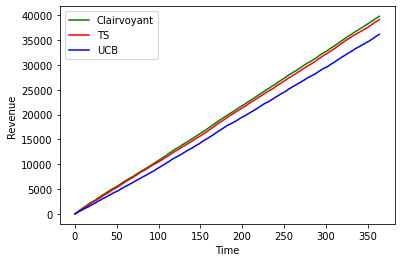

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(c_rewards_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='TS')
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='blue', label='UCB')
#plt.plot(np.cumsum(c_expected_per_day), color='black', label='Expected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')


Text(0, 0.5, 'Regret')

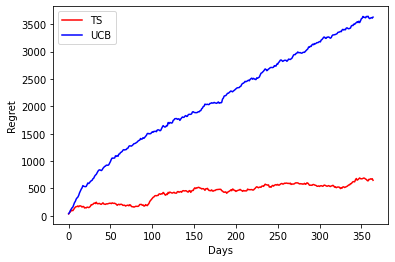

In [16]:
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')